# Loading Libraries

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict


# Loading Data

In [128]:
data_review = pd.read_json("yelp_academic_dataset_review.json", nrows=50000, lines=True)

In [129]:
data_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [130]:
data_review.shape

(50000, 9)

In [131]:
data_review.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [132]:
data = data_review.copy(deep=True)

# Preprocess Data

In [133]:
print("\nPreprocessing Text Data...")
data['text_cleaned'] = (
    data['text']
    .str.lower()
    .str.replace(r'http\S+', '', regex=True)  # Remove URLs
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\d+', '', regex=True)     # Remove numbers
)



Preprocessing Text Data...


In [134]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dgilkey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Sentiment Mapping

In [135]:
def map_sentiment(stars):
    if stars > 2:
        return 2  # Positive
    elif stars ==2:
        return 1  # Neutral
    else:
        return 0  # Negative

In [136]:
data['sentiment_label'] = data['stars'].apply(map_sentiment)

In [137]:
data.sentiment_label.value_counts()

2    40618
0     5379
1     4003
Name: sentiment_label, dtype: int64

In [138]:
data.stars.value_counts()

5    22220
4    12721
3     5677
1     5379
2     4003
Name: stars, dtype: int64

# Data Preparation

In [139]:
X = data['text_cleaned']
y = data['sentiment_label']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


# Loading Transformer

In [141]:
print("\nLoading Transformer Model...")
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/home/dgilkey/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Loading Transformer Model...


In [142]:
def generate_embeddings(texts, tokenizer, model, max_length=128):
    """Generate sentence embeddings using a transformer model."""
    tokens = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)

    
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings


# Embedding Generation

In [ ]:
print("\nGenerating Embeddings for Training Data...")
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)


Generating Embeddings for Training Data...


In [ ]:
print("Generating Embeddings for Testing Data...")
X_test_embeddings = generate_embeddings(X_test.tolist(), tokenizer, model)

# Data Loader Preparation

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        # Convert labels to PyTorch long tensors
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [ ]:
# Create Dataset
train_dataset = SentimentDataset(train_datasetX_train_embeddings, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
, y_train)
test_dataset = SentimentDataset(X_test_embeddings, y_test)

# Create DataLoaders
train_loader = DataLoader(

# Sentiment Classifier

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SentimentClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
input_dim = X_train_embeddings.shape[1]
num_classes = 3  # Negative, Neutral, Positive
model = SentimentClassifier(input_dim, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Model Training

In [ ]:
print("\nTraining the Model...")
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {correct / total:.4f}")

# Model Evaluation

In [174]:
print("\nEvaluating the Model...")
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        outputs = model(embeddings)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))



Evaluating the Model...

Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.66      0.68      1076
     Neutral       0.40      0.20      0.27       800
    Positive       0.92      0.97      0.95      8124

    accuracy                           0.88     10000
   macro avg       0.68      0.61      0.63     10000
weighted avg       0.86      0.88      0.86     10000



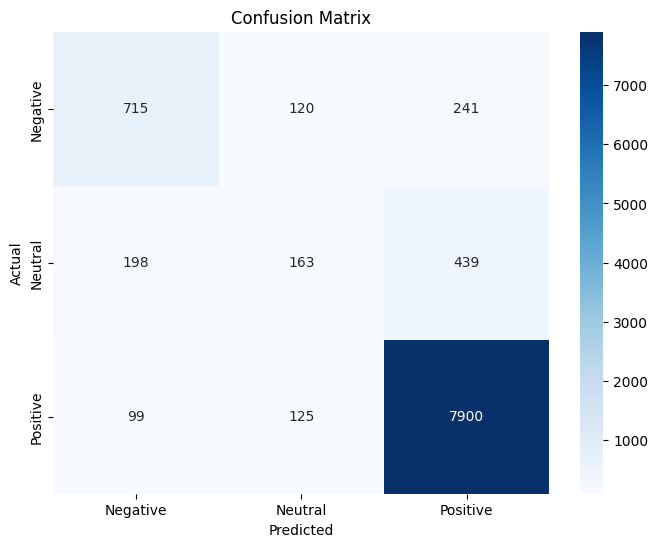

In [175]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Visualizations

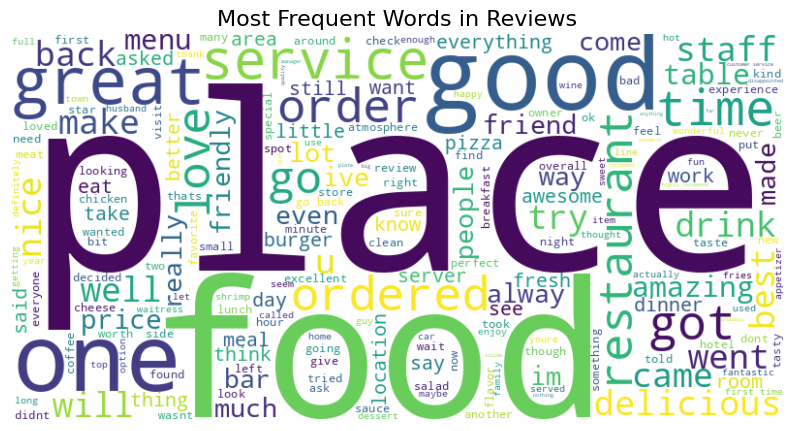

In [165]:
from wordcloud import WordCloud
from collections import Counter

# Generate Word Cloud
all_words = ' '.join(data['text_cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_words)

# Plot Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Reviews", fontsize=16)
plt.show()


/tmp/ipykernel_1703355/357633920.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_freq.values()), y=list(word_freq.keys()), palette='viridis')


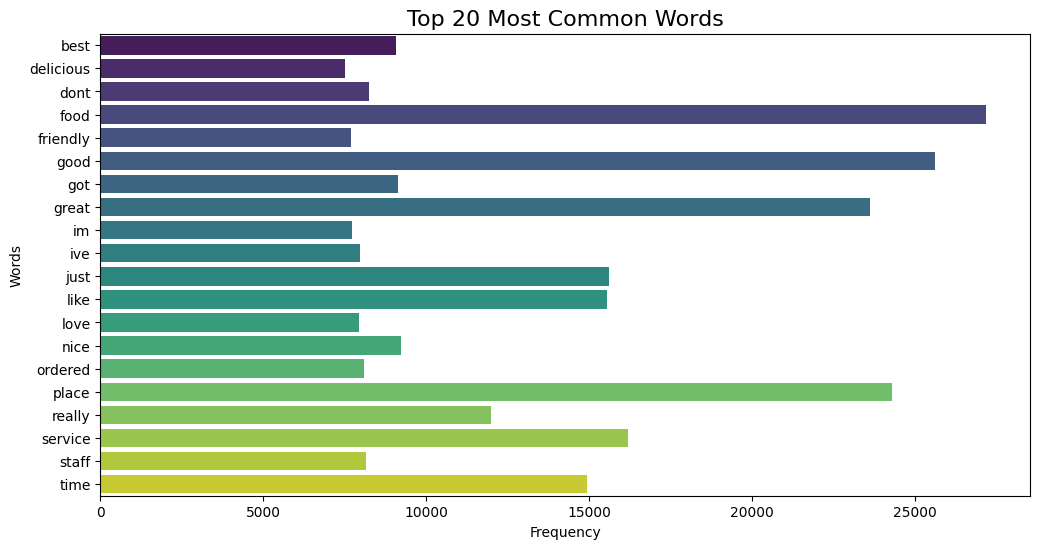

In [166]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(data['text_cleaned'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.toarray().sum(axis=0)))

# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(word_freq.values()), y=list(word_freq.keys()), palette='viridis')
plt.title("Top 20 Most Common Words", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


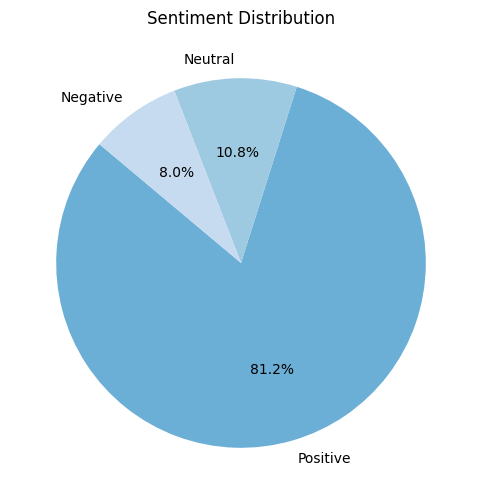

/tmp/ipykernel_1703355/969110400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


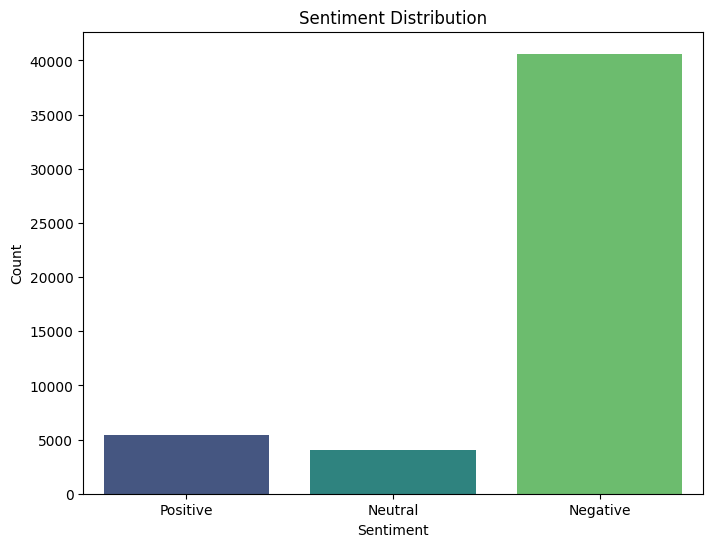

In [167]:
# Sentiment Distribution
sentiment_counts = data['sentiment_label'].value_counts()

# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=["Positive", "Neutral", "Negative"], autopct='%1.1f%%', startangle=140, colors=["#6baed6", "#9ecae1", "#c6dbef"])
plt.title("Sentiment Distribution")
plt.show()

# Bar Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.xticks([0, 1, 2], ["Positive", "Neutral", "Negative"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


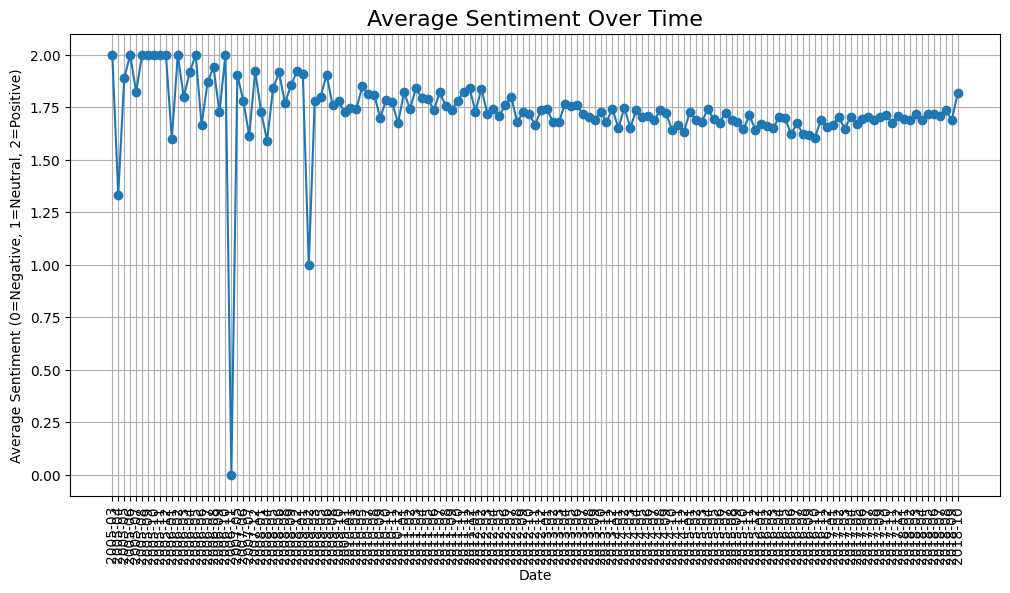

In [168]:
data['date'] = pd.to_datetime(data['date'])  # Ensure date is in datetime format
data['month_year'] = data['date'].dt.to_period('M')  # Group by month and year
sentiment_trend = data.groupby('month_year')['sentiment_label'].mean().reset_index()

# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend['month_year'].astype(str), sentiment_trend['sentiment_label'], marker='o')
plt.title("Average Sentiment Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Average Sentiment (0=Negative, 1=Neutral, 2=Positive)")
plt.xticks(rotation=90)
plt.grid()
plt.show()


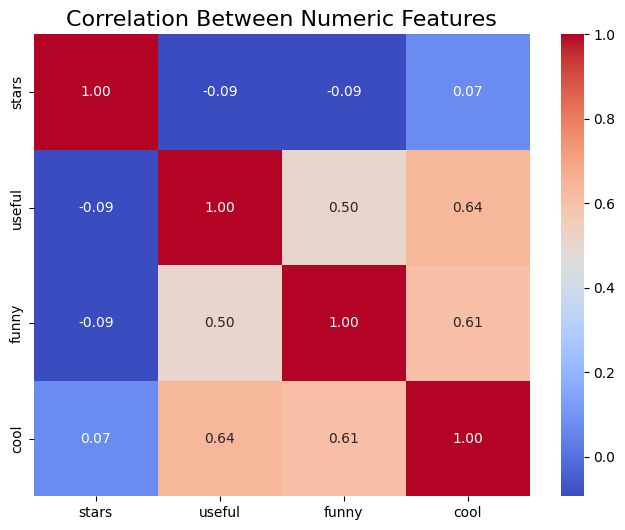

In [169]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data[['stars', 'useful', 'funny', 'cool']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Features", fontsize=16)
plt.show()


/tmp/ipykernel_1703355/835442337.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_label', y='review_length', data=data, palette="viridis")


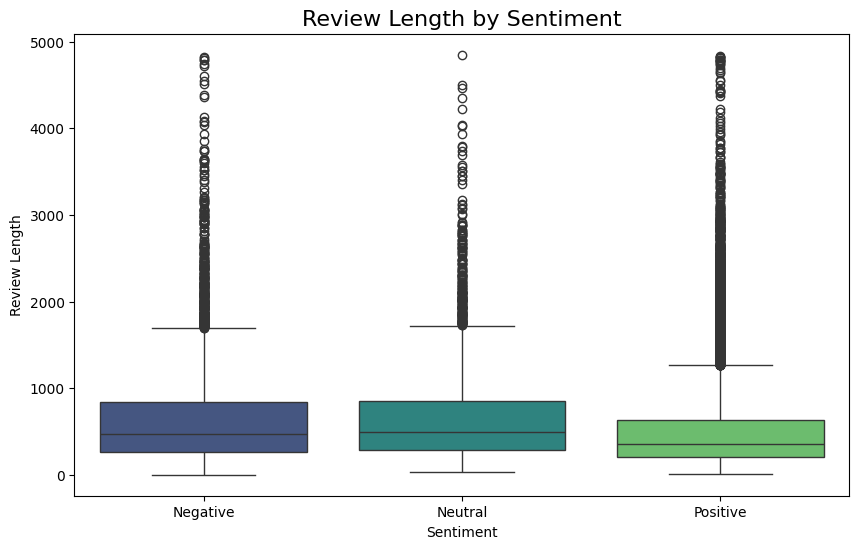

In [170]:
data['review_length'] = data['text_cleaned'].apply(len)

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_label', y='review_length', data=data, palette="viridis")
plt.title("Review Length by Sentiment", fontsize=16)
plt.xlabel("Sentiment")
plt.ylabel("Review Length")
plt.xticks([0, 1, 2], ["Negative", "Neutral", "Positive"])
plt.show()


/tmp/ipykernel_1703355/1853316778.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_by_stars.index, y=sentiment_by_stars.values, palette="viridis")


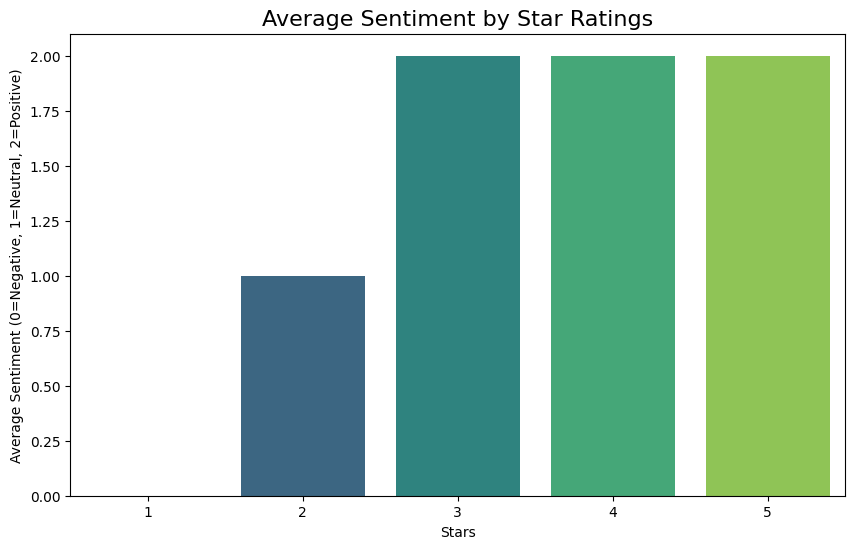

In [171]:
# Group by Stars
sentiment_by_stars = data.groupby('stars')['sentiment_label'].mean()

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_by_stars.index, y=sentiment_by_stars.values, palette="viridis")
plt.title("Average Sentiment by Star Ratings", fontsize=16)
plt.xlabel("Stars")
plt.ylabel("Average Sentiment (0=Negative, 1=Neutral, 2=Positive)")
plt.show()


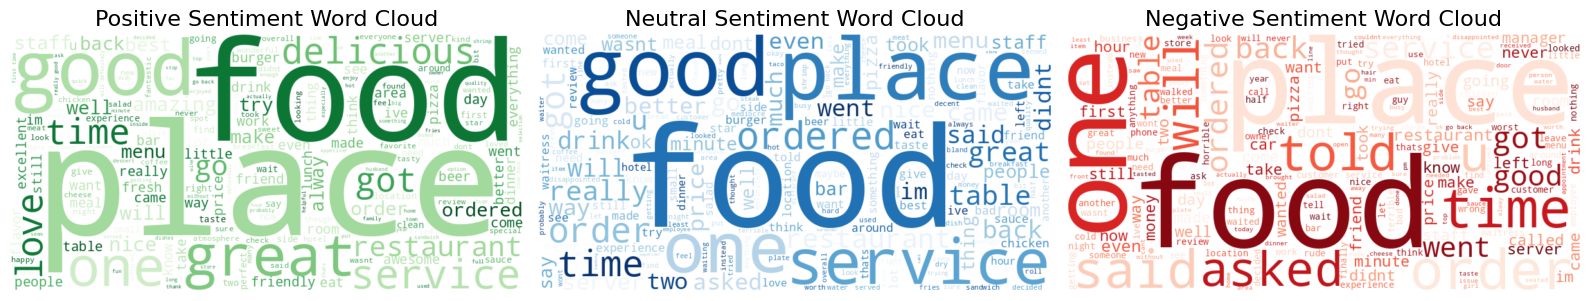

In [172]:
from wordcloud import WordCloud

# Filter Text Based on Sentiments
positive_text = ' '.join(data[data['sentiment_label'] == 2]['text_cleaned'])
neutral_text = ' '.join(data[data['sentiment_label'] == 1]['text_cleaned'])
negative_text = ' '.join(data[data['sentiment_label'] == 0]['text_cleaned'])

# Generate Word Clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
neutral_wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(neutral_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot Word Clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title("Positive Sentiment Word Cloud", fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(neutral_wc, interpolation='bilinear')
plt.title("Neutral Sentiment Word Cloud", fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title("Negative Sentiment Word Cloud", fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_1703355/1829494720.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(positive_words.values()), y=list(positive_words.keys()), palette="Greens_r")
/tmp/ipykernel_1703355/1829494720.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neutral_words.values()), y=list(neutral_words.keys()), palette="Blues_r")
/tmp/ipykernel_1703355/1829494720.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(negative_words.values()), y=list(negative_words.keys()), palette="Reds_r")


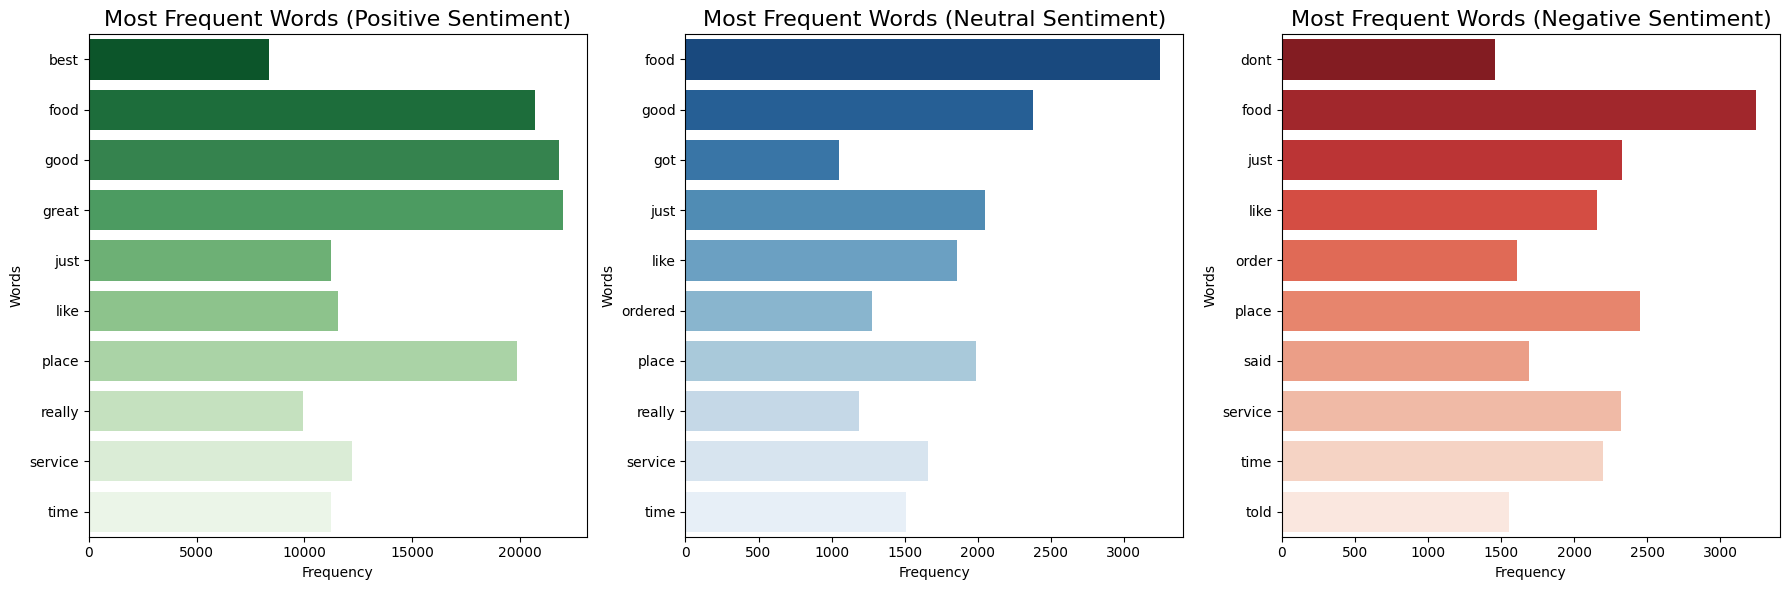

In [173]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to Get Most Frequent Words
def get_most_frequent_words(texts, top_n=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    word_counts = vectorizer.fit_transform(texts)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.toarray().sum(axis=0)))
    return word_freq

# Get Most Frequent Words
positive_words = get_most_frequent_words(data[data['sentiment_label'] == 2]['text_cleaned'], top_n=10)
neutral_words = get_most_frequent_words(data[data['sentiment_label'] == 1]['text_cleaned'], top_n=10)
negative_words = get_most_frequent_words(data[data['sentiment_label'] == 0]['text_cleaned'], top_n=10)

# Plot Most Frequent Words
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x=list(positive_words.values()), y=list(positive_words.keys()), palette="Greens_r")
plt.title("Most Frequent Words (Positive Sentiment)", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Words")

plt.subplot(1, 3, 2)
sns.barplot(x=list(neutral_words.values()), y=list(neutral_words.keys()), palette="Blues_r")
plt.title("Most Frequent Words (Neutral Sentiment)", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Words")

plt.subplot(1, 3, 3)
sns.barplot(x=list(negative_words.values()), y=list(negative_words.keys()), palette="Reds_r")
plt.title("Most Frequent Words (Negative Sentiment)", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Words")

plt.tight_layout()
plt.show()
